In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import warnings
import numpy as np
import pandas as pd
import random

import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
import keras
from keras import optimizers
from keras.datasets import mnist
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.utils import to_categorical

In [3]:
warnings.filterwarnings('ignore')

In [4]:
samples_per_class = 1000

# Domain Split 1

In [ ]:
original_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/dataset/final/subset_10_classes_1.csv")
original_df.emotion.value_counts()

Corn___Common_rust                            1192
Corn___healthy                                1162
Strawberry___Leaf_scorch                      1109
Apple___Apple_scab                            1000
Apple___Black_rot                             1000
Corn___Cercospora_leaf_spot Gray_leaf_spot    1000
Peach___healthy                               1000
Potato___healthy                              1000
Tomato___Early_blight                         1000
Tomato___Tomato_mosaic_virus                  1000
Name: emotion, dtype: int64

In [ ]:
df = pd.DataFrame(columns=['emotion', 'pixels'])

grouped = original_df.groupby('emotion')

for emotion, group_data in grouped:
    if len(group_data) >= samples_per_class:
        selected_samples = group_data.sample(n=samples_per_class, random_state=42)
    else:
        selected_samples = group_data.sample(n=len(group_data), random_state=42)

    df = df.append(selected_samples)

df.reset_index(drop=True, inplace=True)
df.emotion.value_counts()

Apple___Apple_scab                            1000
Apple___Black_rot                             1000
Corn___Cercospora_leaf_spot Gray_leaf_spot    1000
Corn___Common_rust                            1000
Corn___healthy                                1000
Peach___healthy                               1000
Potato___healthy                              1000
Strawberry___Leaf_scorch                      1000
Tomato___Early_blight                         1000
Tomato___Tomato_mosaic_virus                  1000
Name: emotion, dtype: int64

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(84, 84, 3).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(10000, 84, 84, 3)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(10000, 10)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 2, 'Corn___Common_rust': 3, 'Corn___healthy': 4, 'Peach___healthy': 5, 'Potato___healthy': 6, 'Strawberry___Leaf_scorch': 7, 'Tomato___Early_blight': 8, 'Tomato___Tomato_mosaic_virus': 9}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((8000, 84, 84, 3), (2000, 84, 84, 3), (8000, 10), (2000, 10))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

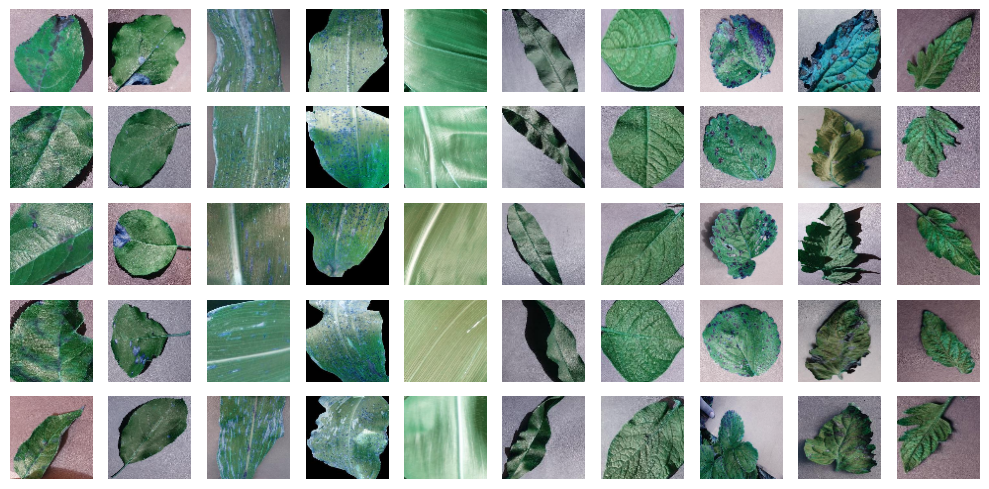

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

width, height, channels = 84, 84, 3

images_per_class = 5
num_classes = 10

unique_emotions = df['emotion'].unique()

plt.figure(figsize=(10, 5))

for i, emotion in enumerate(unique_emotions[:num_classes]):
    # Subset the dataframe for each emotion and get the first 5 images
    subset = df[df['emotion'] == emotion].head(images_per_class)

    # Loop over each image in the subset
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.subplot(images_per_class, num_classes, j * num_classes + i + 1)

        # Convert the pixel values to a 3D array
        pixels = np.fromstring(row['pixels'], sep=' ').astype(np.uint8).reshape(width, height, channels)
        plt.imshow(pixels)

        plt.axis('off')
        if j == (images_per_class - 1):  # This ensures the emotion name is only plotted below the bottom image
            plt.xlabel(emotion, wrap=True)  # `wrap` allows the text to wrap if too long
            plt.xticks([])  # Removes any ticks

plt.tight_layout()
plt.show()


In [ ]:
# a =

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [ ]:
filepath = "/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split1.h5"

checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min')

early_stopping = EarlyStopping(
    monitor='loss',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    checkpoint,
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32
epochs = 30
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1]) # Adam Optimiser

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 42, 42, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 42, 42, 64)        0      

In [ ]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 9.6 MB/s eta 0:00:00


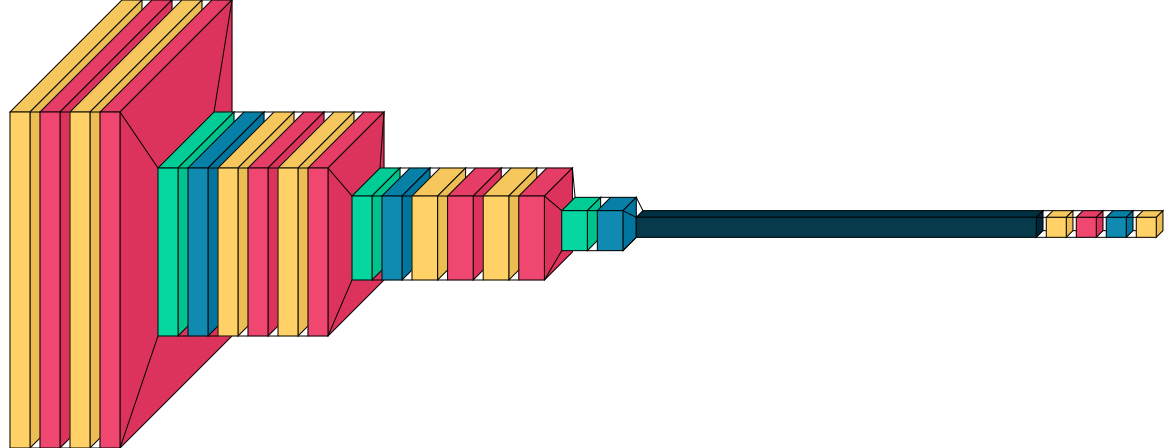

In [ ]:
import visualkeras
visualkeras.layered_view(model)

In [ ]:
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.9542 - accuracy: 0.6890
Epoch 1: loss improved from inf to 0.95422, saving model to /content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split1.h5
250/250 [==============================] - 72s 192ms/step - loss: 0.9542 - accuracy: 0.6890 - val_loss: 5.7476 - val_accuracy: 0.2095 - lr: 0.0010
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.4937 - accuracy: 0.8325
Epoch 2: loss improved from 0.95422 to 0.49367, saving model to /content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split1.h5
250/250 [==============================] - 45s 180ms/step - loss: 0.4937 - accuracy: 0.8325 - val_loss: 1.2380 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.3533 - accuracy: 0.8865
Epoch 3: loss improved from 0.49367 to 0.35326, saving model to /content/drive/MyDrive/Colab Notebooks/villagePlant/tr

# Loss and Accuracy

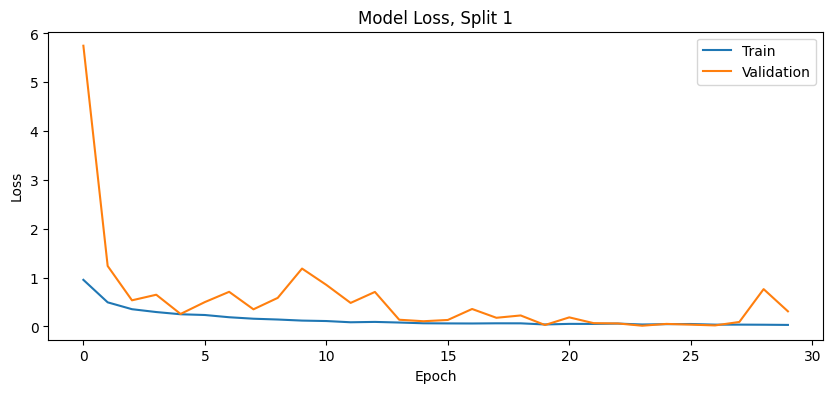

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss, Split 1')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

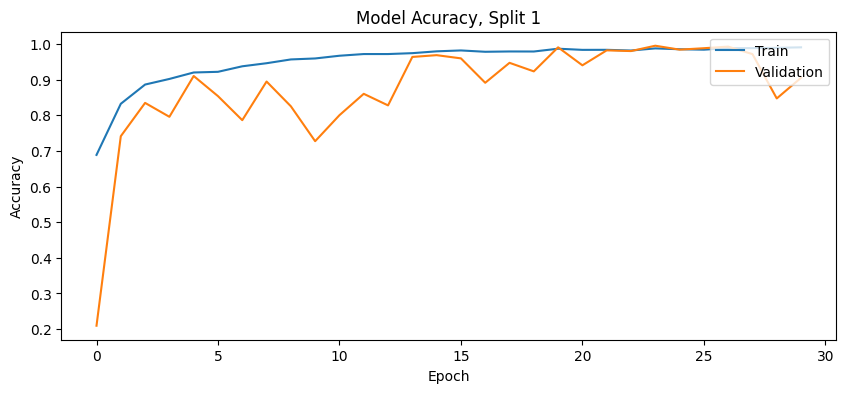

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Acuracy, Split 1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Model Testing

In [ ]:
trained_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split1.h5")
trained_model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 42, 42, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 42, 42, 64)        0      

In [ ]:
loss, accuracy = trained_model.evaluate(X_valid, y_valid)
print("Restored model accuracy : {:.2f}".format(accuracy*100))

63/63 [==============================] - 2s 21ms/step - loss: 0.3097 - accuracy: 0.9055
Restored model accuracy : 90.55


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = trained_model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)
con_matrix = confusion_matrix(y_true, y_pred)
print(con_matrix)

63/63 [==============================] - 2s 21ms/step
[[192   0   0   0   0   0   5   0   0   3]
 [  0 193   0   0   0   0   5   0   1   1]
 [  2   0 190   1   0   0   0   7   0   0]
 [  0   0   0 200   0   0   0   0   0   0]
 [  0   0   0   0 198   0   2   0   0   0]
 [  1  12   0   0   0 103  37   0  14  33]
 [  0   0   0   0   0   0 199   0   0   1]
 [  0   0   0   0   0   0   0 200   0   0]
 [  2   0   0   0   0   0   1  10 136  51]
 [  0   0   0   0   0   0   0   0   0 200]]


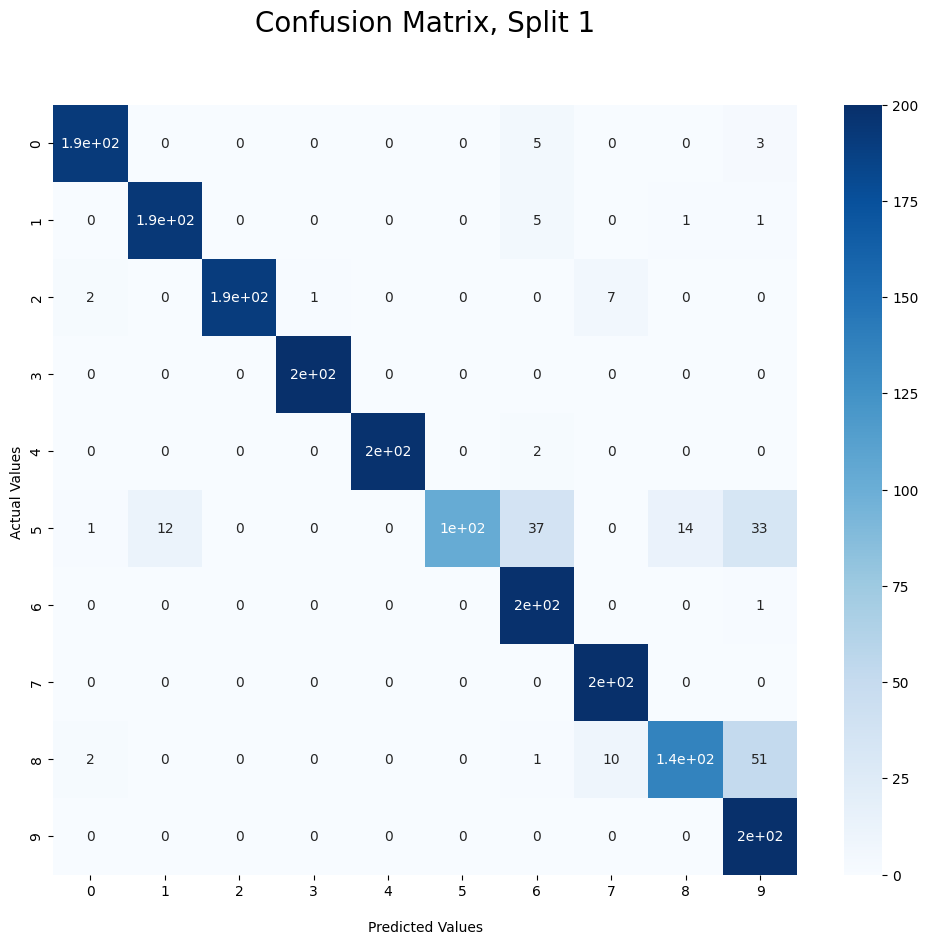

In [ ]:
tick_labels = [value for value in le_name_mapping.keys()]

plt.figure(figsize=(12, 10))
ax = sns.heatmap(con_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix, Split 1\n\n', size=20)
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

# ax.xaxis.set_ticklabels(tick_labels)
# ax.yaxis.set_ticklabels(tick_labels)

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score
f1 = f1_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='micro')

print("F1 Score : {}\nRecall : {}\nPrecision : {}".format(f1, recall, precision))

F1 Score : 0.9055
Recall : 0.9055
Precision : 0.9055


# Domain Split 2

In [ ]:
original_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/dataset/final/subset_10_classes_2.csv")
original_df.emotion.value_counts()

Grape___Esca_(Black_Measles)                  1383
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)    1076
Apple___Black_rot                             1000
Corn___Cercospora_leaf_spot Gray_leaf_spot    1000
Grape___healthy                               1000
Corn___Northern_Leaf_Blight                   1000
Pepper,_bell___Bacterial_spot                 1000
Potato___healthy                              1000
Tomato___Early_blight                         1000
Tomato___Leaf_Mold                            1000
Name: emotion, dtype: int64

In [ ]:
df = pd.DataFrame(columns=['emotion', 'pixels'])

grouped = original_df.groupby('emotion')

for emotion, group_data in grouped:
    if len(group_data) >= samples_per_class:
        selected_samples = group_data.sample(n=samples_per_class, random_state=42)
    else:
        selected_samples = group_data.sample(n=len(group_data), random_state=42)

    df = df.append(selected_samples)

df.reset_index(drop=True, inplace=True)
df.emotion.value_counts()

Apple___Black_rot                             1000
Corn___Cercospora_leaf_spot Gray_leaf_spot    1000
Corn___Northern_Leaf_Blight                   1000
Grape___Esca_(Black_Measles)                  1000
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)    1000
Grape___healthy                               1000
Pepper,_bell___Bacterial_spot                 1000
Potato___healthy                              1000
Tomato___Early_blight                         1000
Tomato___Leaf_Mold                            1000
Name: emotion, dtype: int64

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(84, 84, 3).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
img_array.shape

(10000, 84, 84, 3)

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(10000, 10)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Apple___Black_rot': 0, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 1, 'Corn___Northern_Leaf_Blight': 2, 'Grape___Esca_(Black_Measles)': 3, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 4, 'Grape___healthy': 5, 'Pepper,_bell___Bacterial_spot': 6, 'Potato___healthy': 7, 'Tomato___Early_blight': 8, 'Tomato___Leaf_Mold': 9}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((8000, 84, 84, 3), (2000, 84, 84, 3), (8000, 10), (2000, 10))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

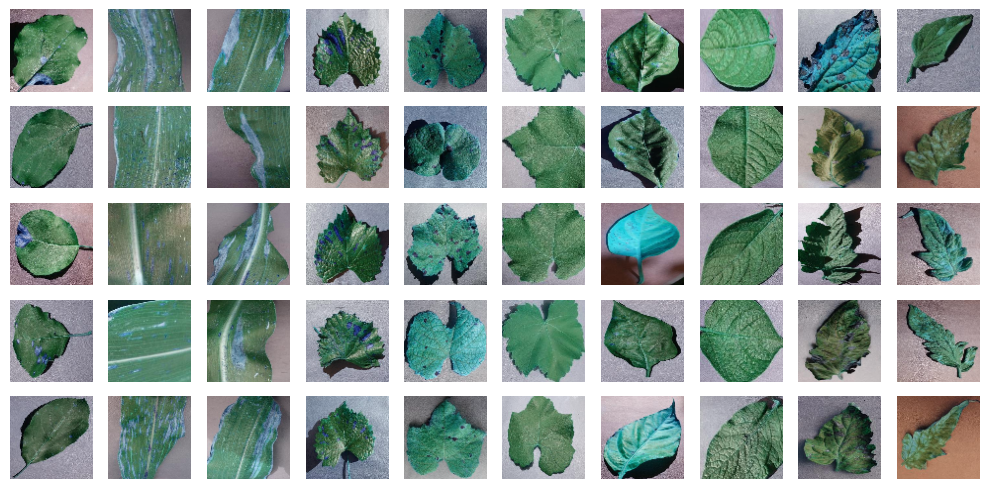

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

width, height, channels = 84, 84, 3

images_per_class = 5
num_classes = 10

unique_emotions = df['emotion'].unique()

plt.figure(figsize=(10, 5))

for i, emotion in enumerate(unique_emotions[:num_classes]):
    # Subset the dataframe for each emotion and get the first 5 images
    subset = df[df['emotion'] == emotion].head(images_per_class)

    # Loop over each image in the subset
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.subplot(images_per_class, num_classes, j * num_classes + i + 1)

        # Convert the pixel values to a 3D array
        pixels = np.fromstring(row['pixels'], sep=' ').astype(np.uint8).reshape(width, height, channels)
        plt.imshow(pixels)

        plt.axis('off')
        if j == (images_per_class - 1):  # This ensures the emotion name is only plotted below the bottom image
            plt.xlabel(emotion, wrap=True)  # `wrap` allows the text to wrap if too long
            plt.xticks([])  # Removes any ticks

plt.tight_layout()
plt.show()


In [ ]:
# a =

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [ ]:
filepath = "/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split2.h5"

checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min')

early_stopping = EarlyStopping(
    monitor='loss',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    checkpoint,
    early_stopping,
    lr_scheduler,
]

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32
epochs = 30
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1]) # Adam Optimiser

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 42, 42, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 42, 42, 64)        0      

In [ ]:
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 1.2889 - accuracy: 0.5570
Epoch 1: loss improved from inf to 1.28892, saving model to /content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split2.h5
250/250 [==============================] - 68s 200ms/step - loss: 1.2889 - accuracy: 0.5570 - val_loss: 6.6987 - val_accuracy: 0.3190 - lr: 0.0010
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.7425
Epoch 2: loss improved from 1.28892 to 0.74182, saving model to /content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split2.h5
250/250 [==============================] - 51s 204ms/step - loss: 0.7418 - accuracy: 0.7425 - val_loss: 0.7507 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.8011
Epoch 3: loss improved from 0.74182 to 0.54900, saving model to /content/drive/MyDrive/Colab Notebooks/villagePlant/tr

# Loss and Accuracy

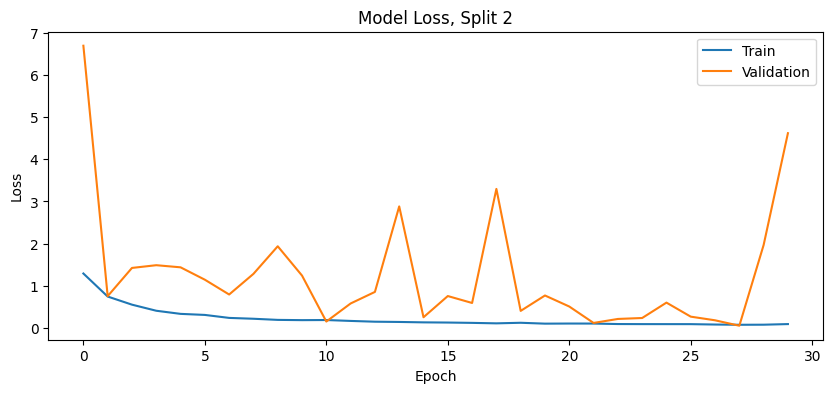

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss, Split 2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

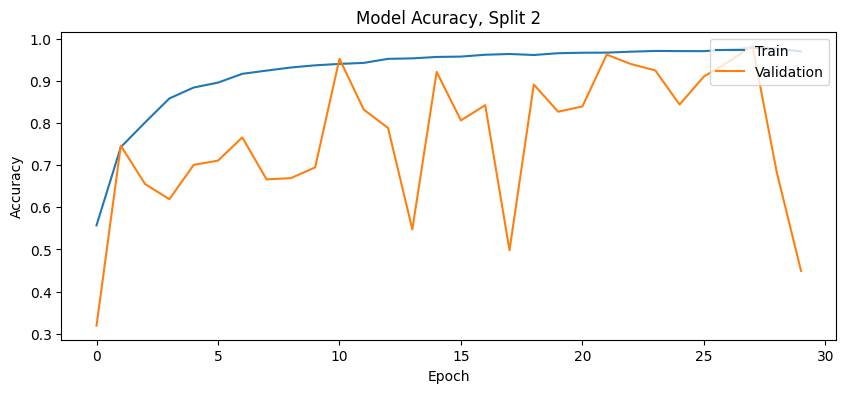

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Acuracy, Split 2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Model Testing

In [ ]:
trained_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split2.h5")
trained_model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 42, 42, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 42, 42, 64)        0      

In [ ]:
loss, accuracy = trained_model.evaluate(X_valid, y_valid)
print("Restored model accuracy : {:.2f}".format(accuracy*100))

63/63 [==============================] - 2s 22ms/step - loss: 0.0487 - accuracy: 0.9830
Restored model accuracy : 98.30


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = trained_model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)
con_matrix = confusion_matrix(y_true, y_pred)
print(con_matrix)

63/63 [==============================] - 1s 19ms/step
[[199   0   0   1   0   0   0   0   0   0]
 [  0 193   7   0   0   0   0   0   0   0]
 [  0  19 181   0   0   0   0   0   0   0]
 [  0   0   0 200   0   0   0   0   0   0]
 [  0   0   0   0 200   0   0   0   0   0]
 [  0   0   0   0   0 200   0   0   0   0]
 [  2   0   0   0   0   0 198   0   0   0]
 [  0   0   0   0   0   0   0 200   0   0]
 [  1   0   0   2   0   0   1   0 195   1]
 [  0   0   0   0   0   0   0   0   0 200]]


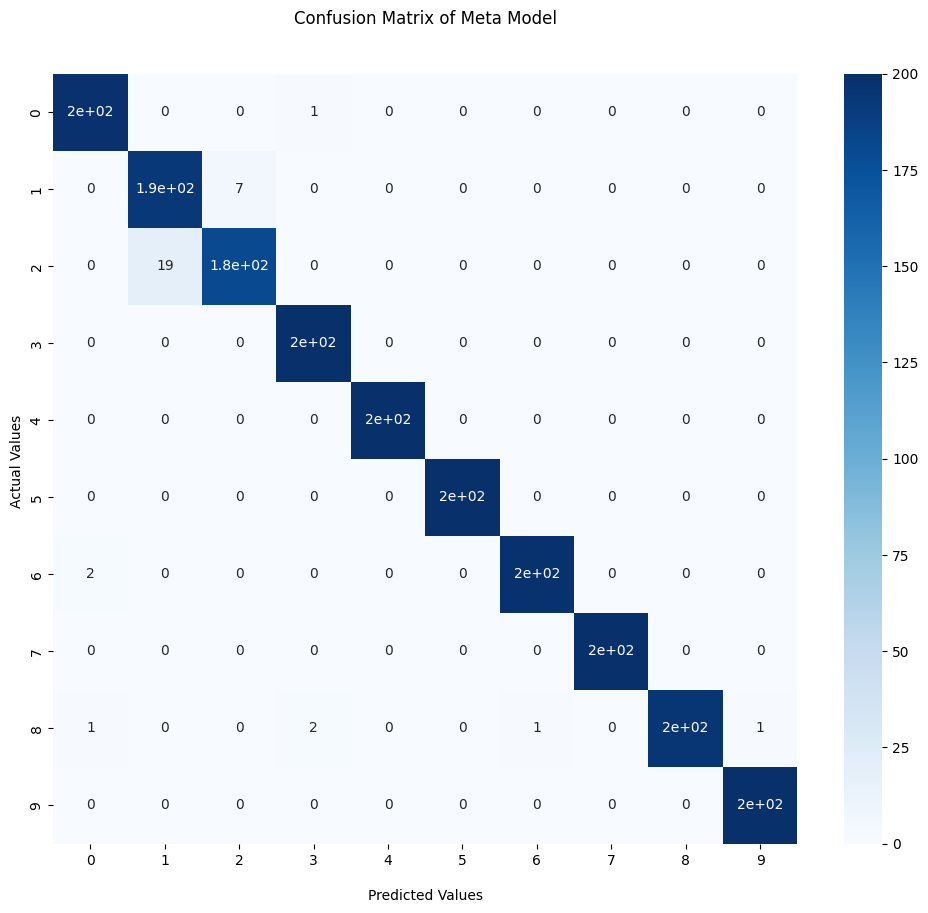

In [29]:
tick_labels = [value for value in le_name_mapping.keys()]

plt.figure(figsize=(12, 10))
ax = sns.heatmap(con_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix of Meta Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# ax.xaxis.set_ticklabels(tick_labels)
# ax.yaxis.set_ticklabels(tick_labels)

plt.show()

In [30]:
from sklearn.metrics import f1_score, recall_score, precision_score
f1 = f1_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='micro')

print("F1 Score : {}\nRecall : {}\nPrecision : {}".format(f1, recall, precision))

F1 Score : 0.983
Recall : 0.983
Precision : 0.983


# Domain Split 3

In [5]:
original_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/villagePlant/dataset/final/subset_10_classes_3.csv")
original_df.emotion.value_counts()

Pepper,_bell___healthy                        1478
Corn___Common_rust                            1192
Grape___Black_rot                             1180
Strawberry___Leaf_scorch                      1109
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)    1076
Cherry___Powdery_mildew                       1052
Grape___healthy                               1000
Peach___healthy                               1000
Potato___healthy                              1000
Tomato___Early_blight                         1000
Name: emotion, dtype: int64

In [6]:
df = pd.DataFrame(columns=['emotion', 'pixels'])

grouped = original_df.groupby('emotion')

for emotion, group_data in grouped:
    if len(group_data) >= samples_per_class:
        selected_samples = group_data.sample(n=samples_per_class, random_state=42)
    else:
        selected_samples = group_data.sample(n=len(group_data), random_state=42)

    df = df.append(selected_samples)

df.reset_index(drop=True, inplace=True)
df.emotion.value_counts()

Cherry___Powdery_mildew                       1000
Corn___Common_rust                            1000
Grape___Black_rot                             1000
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)    1000
Grape___healthy                               1000
Peach___healthy                               1000
Pepper,_bell___healthy                        1000
Potato___healthy                              1000
Strawberry___Leaf_scorch                      1000
Tomato___Early_blight                         1000
Name: emotion, dtype: int64

In [7]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(84, 84, 3).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [8]:
img_array.shape

(10000, 84, 84, 3)

In [9]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(10000, 10)

In [10]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Cherry___Powdery_mildew': 0, 'Corn___Common_rust': 1, 'Grape___Black_rot': 2, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 3, 'Grape___healthy': 4, 'Peach___healthy': 5, 'Pepper,_bell___healthy': 6, 'Potato___healthy': 7, 'Strawberry___Leaf_scorch': 8, 'Tomato___Early_blight': 9}


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((8000, 84, 84, 3), (2000, 84, 84, 3), (8000, 10), (2000, 10))

In [12]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [13]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

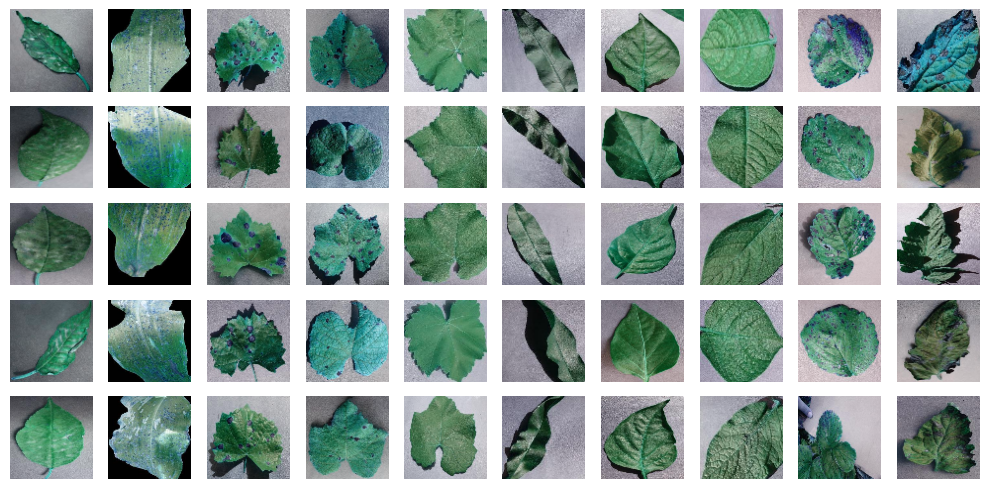

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

width, height, channels = 84, 84, 3

images_per_class = 5
num_classes = 10

unique_emotions = df['emotion'].unique()

plt.figure(figsize=(10, 5))

for i, emotion in enumerate(unique_emotions[:num_classes]):
    # Subset the dataframe for each emotion and get the first 5 images
    subset = df[df['emotion'] == emotion].head(images_per_class)

    # Loop over each image in the subset
    for j, (_, row) in enumerate(subset.iterrows()):
        plt.subplot(images_per_class, num_classes, j * num_classes + i + 1)

        # Convert the pixel values to a 3D array
        pixels = np.fromstring(row['pixels'], sep=' ').astype(np.uint8).reshape(width, height, channels)
        plt.imshow(pixels)

        plt.axis('off')
        if j == (images_per_class - 1):  # This ensures the emotion name is only plotted below the bottom image
            plt.xlabel(emotion, wrap=True)  # `wrap` allows the text to wrap if too long
            plt.xticks([])  # Removes any ticks

plt.tight_layout()
plt.show()


In [ ]:
# a =

In [15]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [16]:
filepath = "/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split3.h5"

checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min')

early_stopping = EarlyStopping(
    monitor='loss',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    checkpoint,
    early_stopping,
    lr_scheduler,
]

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [18]:
batch_size = 32
epochs = 30
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

model = build_net(optims[1]) # Adam Optimiser

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 42, 42, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 42, 42, 64)        0      

In [19]:
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 1.0396 - accuracy: 0.6634
Epoch 1: loss improved from inf to 1.03963, saving model to /content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split3.h5
250/250 [==============================] - 65s 186ms/step - loss: 1.0396 - accuracy: 0.6634 - val_loss: 2.3000 - val_accuracy: 0.5490 - lr: 0.0010
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.5829 - accuracy: 0.8060
Epoch 2: loss improved from 1.03963 to 0.58287, saving model to /content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split3.h5
250/250 [==============================] - 43s 172ms/step - loss: 0.5829 - accuracy: 0.8060 - val_loss: 2.1951 - val_accuracy: 0.5085 - lr: 0.0010
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8597
Epoch 3: loss improved from 0.58287 to 0.42902, saving model to /content/drive/MyDrive/Colab Notebooks/villagePlant/tr

# Loss and Accuracy

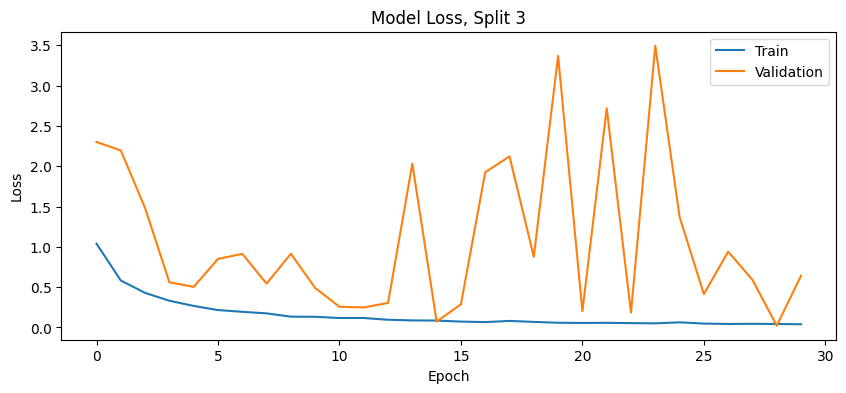

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss, Split 3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

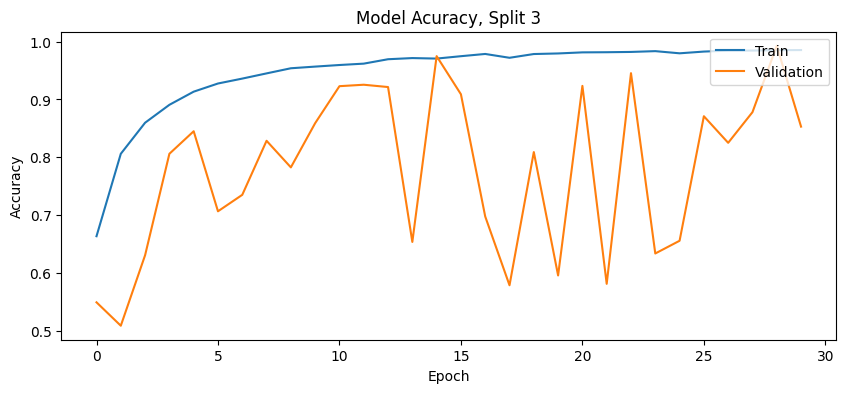

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Acuracy, Split 3')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Model Testing

In [22]:
trained_model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/villagePlant/trained_models/meta_model_split3.h5")
trained_model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        4864      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 84, 84, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 42, 42, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 42, 42, 64)        0      

In [23]:
loss, accuracy = trained_model.evaluate(X_valid, y_valid)
print("Restored model accuracy : {:.2f}".format(accuracy*100))

63/63 [==============================] - 2s 22ms/step - loss: 0.6419 - accuracy: 0.8530
Restored model accuracy : 85.30


In [24]:
from sklearn.metrics import confusion_matrix
y_pred = trained_model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)
con_matrix = confusion_matrix(y_true, y_pred)
print(con_matrix)

63/63 [==============================] - 1s 19ms/step
[[177   0   0  12   0   0   0  10   1   0]
 [  0 198   0   0   0   0   0   0   2   0]
 [  0   0 158  42   0   0   0   0   0   0]
 [  0   0   0 200   0   0   0   0   0   0]
 [  0   0   0  48 146   0   0   6   0   0]
 [  0   0   0   1   0 164   1  34   0   0]
 [  0   0   0   1   0   0 147  52   0   0]
 [  0   0   0   0   0   0   0 200   0   0]
 [  0   0   0   0   0   0   0   0 200   0]
 [  0   0   2  66   0   0   0  10   6 116]]


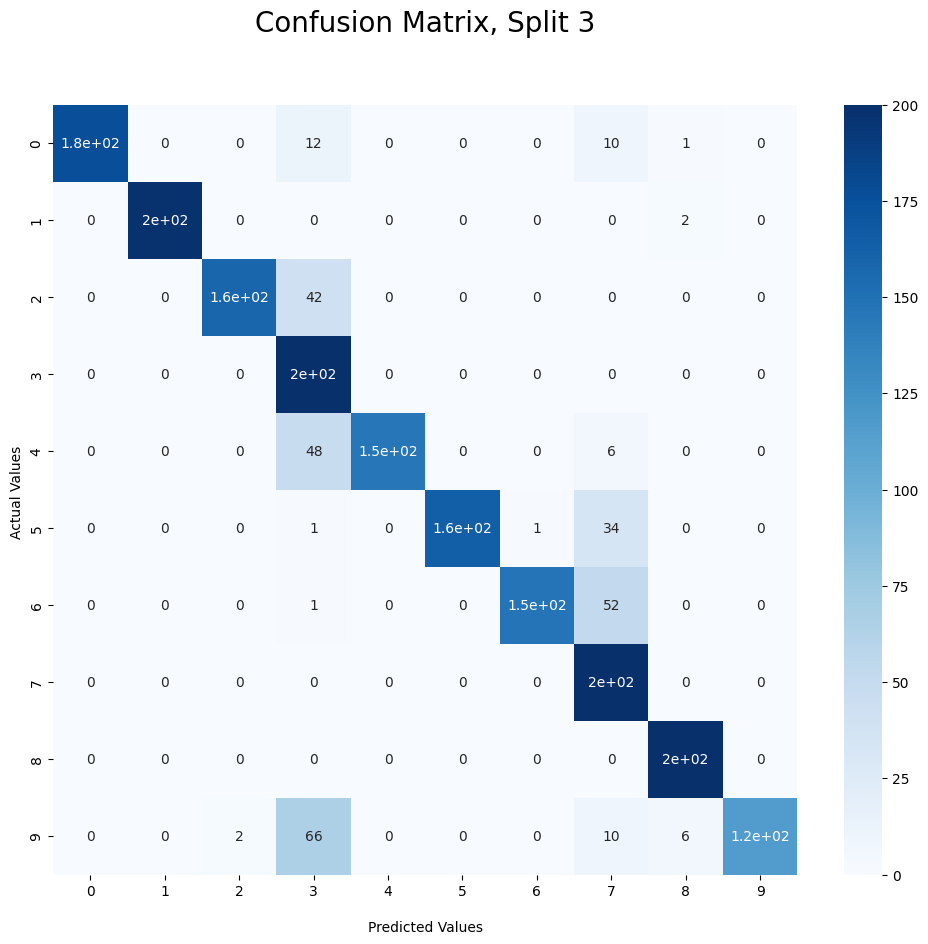

In [30]:
tick_labels = [value for value in le_name_mapping.keys()]

plt.figure(figsize=(12, 10))
ax = sns.heatmap(con_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix, Split 3\n\n', size=20)
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

# ax.xaxis.set_ticklabels(tick_labels)
# ax.yaxis.set_ticklabels(tick_labels)

plt.show()

In [31]:
from sklearn.metrics import f1_score, recall_score, precision_score
f1 = f1_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='micro')

print("F1 Score : {}\nRecall : {}\nPrecision : {}".format(f1, recall, precision))

F1 Score : 0.853
Recall : 0.853
Precision : 0.853
